# Prediction of the INDPRO index

## Library import

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data import

In [3]:
df = pd.read_csv('case.csv')

# Dataset analysis

In [4]:
df.head(10)

,y,x1,x2,x3,x4,x5
0,NaN,2.456,4.00,1386.96,6.4,406426
1,104.7474,2.837,4.04,1462.59,4.4,405948
2,104.8129,2.578,3.56,1736.47,4.6,405466
3,104.4135,2.793,3.13,1688.85,18.0,403957
4,104.4852,3.283,3.10,1822.57,4.4,400415
5,103.9464,4.049,3.25,1824.05,11.7,394222
6,104.1646,3.750,3.07,2164.81,9.6,385212
7,104.2709,3.180,2.81,1967.01,19.9,374527
8,103.5717,3.197,2.41,2224.28,24.8,363887
9,102.8987,2.648,2.25,2286.50,21.5,354222


In [5]:
df.tail(10)

,y,x1,x2,x3,x4,x5
265,92.8361,0.879,5.80,1952.0,23.7,120652
266,93.1547,0.914,5.83,1903.0,31.7,119957
267,92.7900,0.850,5.72,2023.1,23.0,119275
268,93.0400,0.829,5.85,2092.8,25.2,118606
269,93.2168,0.959,5.93,2008.0,12.4,117956
270,93.1620,0.896,6.15,2209.9,20.9,117295
271,92.8872,0.732,5.85,2391.2,14.7,116631
272,92.3118,0.857,6.05,1946.3,19.4,115932
273,91.9626,0.819,6.23,1852.9,37.9,115573
274,91.6261,0.695,6.63,1570.9,22.6,115232


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       274 non-null    float64
 1   x1      275 non-null    float64
 2   x2      275 non-null    float64
 3   x3      275 non-null    float64
 4   x4      275 non-null    float64
 5   x5      275 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.0 KB


In [7]:
df.describe()

,y,x1,x2,x3,x4,x5
count,274.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,96.864250,1.775498,3.842655,2169.204364,18.167636,202433.625455
std,4.975902,0.734485,1.219188,562.837890,10.934924,62477.509237
min,84.727700,0.501000,1.270000,1017.800000,-18.600000,115232.000000
25%,92.801525,1.199500,2.895000,1780.335000,11.050000,152395.000000
50%,98.201700,1.702000,3.790000,2233.370000,18.900000,190174.000000
75%,101.001500,2.305000,4.850000,2438.665000,25.450000,243584.500000
max,104.812900,4.049000,6.630000,3812.550000,41.200000,406426.000000


In [8]:
df.shape

(275, 6)

In [9]:
len(df["x5"].value_counts())

275

x5 variable contains only unique values - it is also numeric, not categorical variable <br><br>
We can also observe that y has one missing value. <br>
The percentage of missing data:

In [10]:
round(df.y.isnull().sum()/len(df.y),5)

0.00364

Because we are nowcasting the value of the INDPRO index, which is Industrial Production: Total Index of US, we can assume that the received data is a time series.<br>
In that case we can not fulfill the missing data with mean or median value, because most likely the values ​​follow a certain trend over time. <br>
We can see in second row the value of y much differs from mean or median y values. <br>
I chose backfill method, which use next valid observation to fill gap.

In [11]:
df.y.fillna(method='bfill', inplace=True)

# Outliers

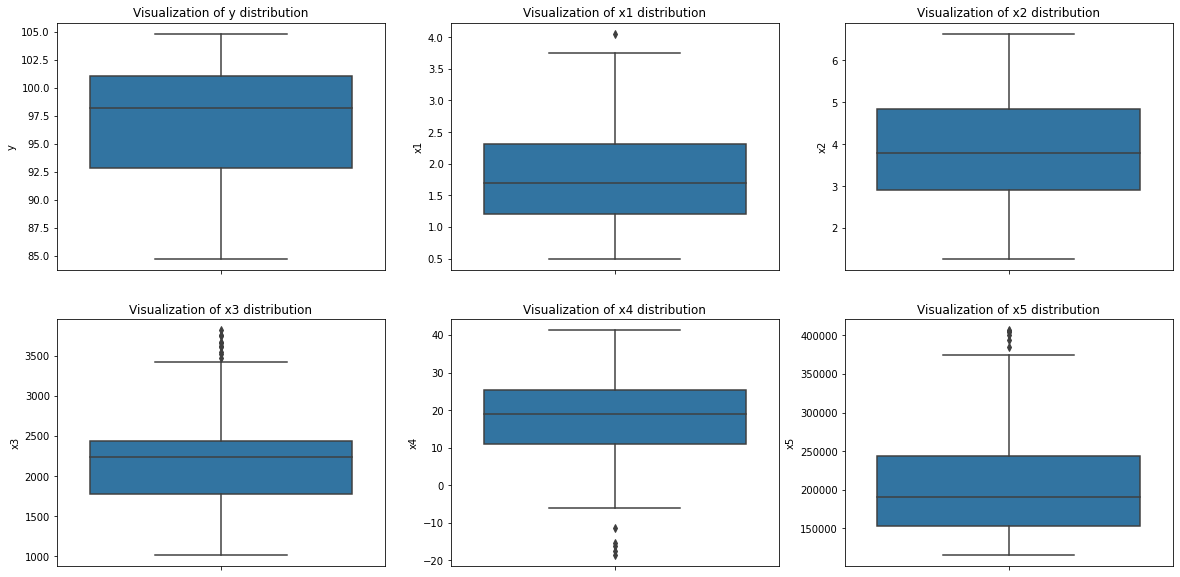

In [17]:
def graph_maker(variables):
    plt.figure(figsize=(20,10))
    for i in range(1,7):
        plt.subplot(2,3,i)
        plt.title(f'Visualization of {variables[i-1]} distribution')
        ax = sns.boxplot(y=variables[i-1], data=df)

variables_list = list(df.columns)        
graph_maker(variables_list)

# Distribution of variables

array([[<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'x1'}>],
       [<AxesSubplot:title={'center':'x2'}>,
        <AxesSubplot:title={'center':'x3'}>],
       [<AxesSubplot:title={'center':'x4'}>,
        <AxesSubplot:title={'center':'x5'}>]], dtype=object)

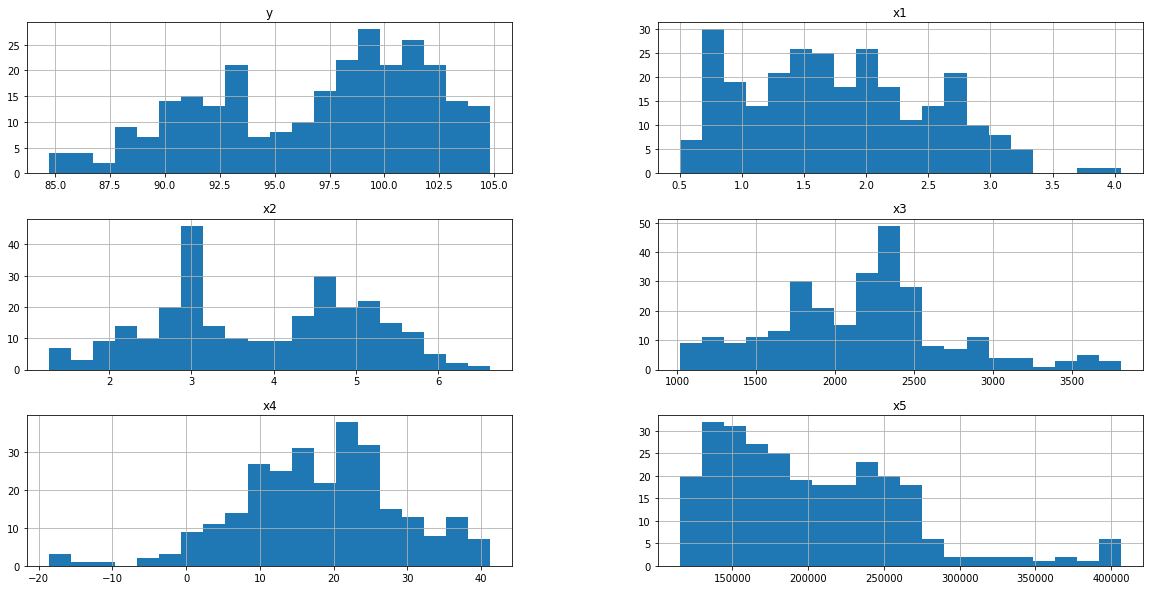

In [18]:
df.hist(bins=20, figsize=(20,10))

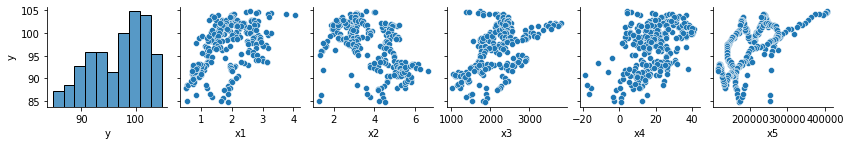

In [24]:
ax = sns.pairplot(df, height=2, y_vars="y")

The distribution of variables does not resemble a normal distribution. <br>
I decided not to remove outliers from the dataset, because if it is a time series the outliers may not be accidental, but still a part of some trend just reaching its extreme. <br>
We can see a prof of that in the last plot above, where the values ​​of the variable x5 are constantly increasing to reach extreme values.

# Correlation matrix

A strong correlation of the explained variable y with the explanatory variables x1, x2, x3, x4 and x5 is visible. <br>
Especially in the case of x5 variable. <br>
There is much less correlation between explanatory variables, except for variables x1 and x3.

In [25]:
df.corr().style.background_gradient(cmap='coolwarm')

,y,x1,x2,x3,x4,x5
y,1.000000,0.517881,-0.512093,0.525166,0.437336,0.619732
x1,0.517881,1.000000,-0.325349,0.588092,0.014828,0.300803
x2,-0.512093,-0.325349,1.000000,-0.093386,-0.260255,-0.444225
x3,0.525166,0.588092,-0.093386,1.000000,0.128149,0.253498
x4,0.437336,0.014828,-0.260255,0.128149,1.000000,0.245394
x5,0.619732,0.300803,-0.444225,0.253498,0.245394,1.000000


# Dataset split into train and test sets

In [26]:
y = df['y']
X = df.drop('y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Model selection

Models XGBRegressor, RandomForestRegressor and GradientBoostingRegressor gave the best results.<br>
We chose XGBRegressor as the final model.

In [32]:
def model_stats(models):
    colnames = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
    indices = ['MAE', 'MSE', 'RMSE', 'R2']
    df_scores = pd.DataFrame(index = indices, columns = colnames)
    for i in range(0,5):
        model_scores = []
        model = models[i]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        one_model_score = [mae, mse, rmse, r2]
        df_scores[colnames[i]] = one_model_score
    return df_scores

models_list = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), XGBRegressor()]
model_stats(models_list)

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor
MAE,2.078885,1.289790,0.944545,0.981447,0.848892
MSE,7.613808,5.210338,2.402155,2.724804,1.744241
RMSE,2.759313,2.282616,1.549889,1.650698,1.320697
R2,0.638939,0.752916,0.886085,0.870785,0.917285


# Final model

After changing a few parameters of the final model, a slight improvement was achieved.

In [40]:
final_model = XGBRegressor(n_estimators=68, num_parallel_tree = 2)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 0.8465455866434487
MSE: 1.7398056763532792
RMSE: 1.3190169355824357
R2: 0.9174950681466147


# Cross validation

In [35]:
scores = cross_val_score(final_model, X, y, cv=10, scoring='neg_mean_squared_error')
final_model_rmse_scores = np.sqrt(-scores)
print("RMSE Scores: ", final_model_rmse_scores)

RMSE Scores:  [7.57776066 4.05551753 1.96109792 5.04602869 3.41104678 7.19264414
 2.98648512 2.71082383 1.99744212 1.79107114]


# Feature importances

In [36]:
importances = pd.Series(data=final_model.feature_importances_, index=X_train.columns)
importances[importances > 0].sort_values(ascending=False)

x5    0.419024
x4    0.201608
x2    0.148070
x1    0.136377
x3    0.094920
dtype: float32

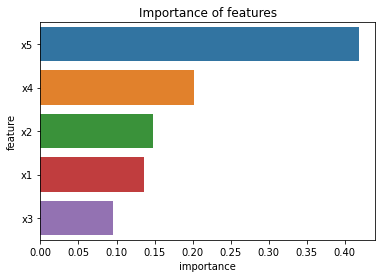

In [45]:
importance_df = pd.DataFrame(importances[importances > 0].sort_values(ascending=False).items(), columns=["feature", "importance"])
ax = sns.barplot(data=importance_df, x="importance", y="feature").set(title = "Importance of features")

As we can see in the plot above, the feature that best describes variable y was x5 and the least x3.

# Saving model

In [ ]:
joblib.dump(final_model, "final_model.pkl")